# Bulk RNA-seq Reproducibility Analysis: Final Differential Expression Analysis

## Overview
This notebook performs comprehensive differential expression analysis of bulk RNA-seq data to assess reproducibility across experimental conditions and genotypes. The analysis includes DESeq2-based differential expression testing, batch correction, distance analysis, and visualization of expression patterns.

## Analysis Workflow
1. **Configuration and Data Loading**: Load expression data and metadata from reproducibility experiments
2. **Quality Control**: Filter samples based on library size and assess data quality
3. **DESeq2 Analysis**: Perform differential expression analysis with proper design matrix
4. **Batch Correction**: Apply limma batch correction to account for technical variation
5. **Visualization**: Generate PCA plots, heatmaps, and distance matrices
6. **Marker Gene Analysis**: Identify sample-specific marker genes using pairwise contrasts
7. **Results Export**: Save normalized counts, corrected data, and differential expression results

## Input Files
- `bulk/reproducibility_genotypes.tsv`: Combined expression count matrix from all experiments
- `bulk/reproducibility_genotypes_meta.tsv`: Sample metadata with experimental information

## Output Files
- `bulk/reproducibility_genotypes_deseq2_vsd.tsv`: Variance stabilized expression data
- `bulk/reproducibility_genotypes_deseq2_vsd_corr.tsv`: Batch-corrected expression data
- `bulk/reproducibility_genotypes_deseq2_limma_corr_pca_distances.tsv`: Sample distance matrix
- `stability_plots/[sample]_deseq2.tsv`: Differential expression results per sample
- `stability_plots/[sample]_deseq2.png`: Volcano plots per sample

## Requirements
- DESeq2, limma, ggplot2, dplyr, EnhancedVolcano, pheatmap
- Input data from previous reproducibility data collection step

## Configuration and Library Loading

In [ ]:
# =============================================================================
# CONFIGURATION AND PARAMETERS
# =============================================================================

# Set random seed for reproducibility
set.seed(42)

# File paths
DATA_DIR <- "bulk"
OUTPUT_DIR <- "stability_plots"
INPUT_COUNTS_FILE <- "reproducibility_genotypes.tsv"
INPUT_META_FILE <- "reproducibility_genotypes_meta.tsv"

# Analysis parameters
MIN_COUNT_THRESHOLD <- 600000  # Minimum library size threshold
MIN_GENE_COUNT <- 10           # Minimum gene count threshold for filtering
N_TOP_GENES <- 20              # Number of top genes for heatmaps

# Plot parameters
PLOT_WIDTH <- 8
PLOT_HEIGHT <- 8
HEATMAP_WIDTH <- 15
HEATMAP_HEIGHT <- 40

# Create output directory if it doesn't exist
if (!dir.exists(OUTPUT_DIR)) {
  dir.create(OUTPUT_DIR, recursive = TRUE)
}

cat("Configuration loaded successfully!\n")
cat("Data directory:", DATA_DIR, "\n")
cat("Output directory:", OUTPUT_DIR, "\n")
cat("Minimum count threshold:", MIN_COUNT_THRESHOLD, "\n")

# =============================================================================
# LIBRARY LOADING
# =============================================================================

# Load required libraries with suppressed startup messages
suppressPackageStartupMessages({
  library(DESeq2)
  library(useful) 
  library(ggplot2) 
  library(dplyr) 
  library(limma) 
  library(EnhancedVolcano) 
  library(biomaRt) 
  library(gridExtra) 
  library(repr)
  library(pheatmap)
  library(RColorBrewer)
  library(vsn)
})

cat("Libraries loaded successfully!\n")
cat("DESeq2 version:", as.character(packageVersion("DESeq2")), "\n")
cat("limma version:", as.character(packageVersion("limma")), "\n")

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




## 1. Data Loading and Initial Assessment

In [ ]:
# =============================================================================
# DATA LOADING
# =============================================================================

cat("Loading expression data and metadata...\n")

# Load expression count matrix
counts_file <- file.path(DATA_DIR, INPUT_COUNTS_FILE)
if (!file.exists(counts_file)) {
  stop("Counts file not found: ", counts_file)
}
data <- read.csv(counts_file, sep="\t", header=TRUE, quote="", row.names=1)
cat("✓ Expression data loaded:", nrow(data), "genes x", ncol(data), "samples\n")

# Load sample metadata
meta_file <- file.path(DATA_DIR, INPUT_META_FILE)
if (!file.exists(meta_file)) {
  stop("Metadata file not found: ", meta_file)
}
meta <- read.csv(meta_file, sep="\t", header=TRUE, row.names=1, quote="")
cat("✓ Metadata loaded:", nrow(meta), "samples\n")

# Display data overview
cat("\nData overview:\n")
corner(data)
cat("\nMetadata overview:\n")
print(head(meta))
cat("\nSample summary by genotype:\n")
print(table(meta$genotype))

,Reproducibility_SC102A1_1_4,Reproducibility_SC102A1_1_9,Reproducibility_SC102A1_3_7,Reproducibility_SC102A1_2_12,Reproducibility_SC102A1_3_8
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,2,0,0,1
A1BG,3,0,8,6,2
A1BG-AS1,5,8,23,4,9


## 2. Quality Control and Sample Filtering

                              counts
Reproducibility_SC102A1_2_12  695566
Reproducibility_409B2_3_9     720228
Reproducibility_SC102A1_2_10  768748
Reproducibility_409B2_3_8     876837
Reproducibility_SC102A1_1_4  1040799
Reproducibility_409B2_1_9    1066426
Reproducibility_409B2_1_10   1102864
Reproducibility_409B2_2_11   1128000
Reproducibility_409B2_3_10   1136538
Reproducibility_SC102A1_3_3  1157263
Reproducibility_SC102A1_2_6  1198406
Reproducibility_SC102A1_2_9  1208195
Reproducibility_409B2_1_11   1259250
Reproducibility_SC102A1_2_8  1350194
Reproducibility_409B2_1_12   1371291
Reproducibility_SC102A1_2_5  1475911
Reproducibility_SC102A1_1_10 1489394
Reproducibility_409B2_2_12   1510898
Reproducibility_SC102A1_3_10 1653625
Reproducibility_409B2_3_7    1654714


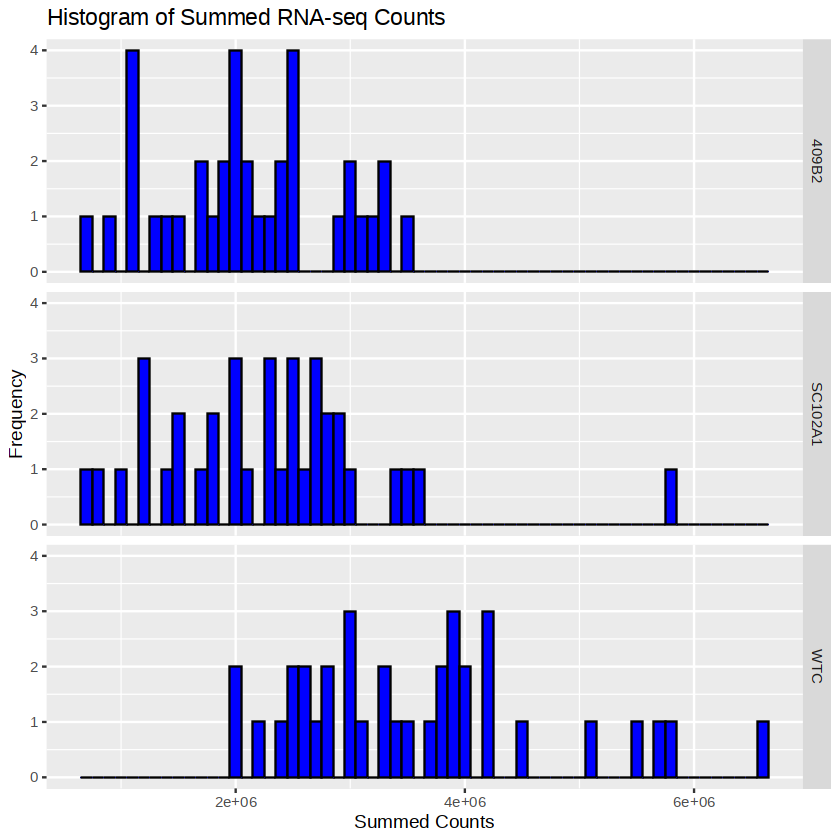

In [ ]:
# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

meta['counts'] <- colSums(data)

options(repr.plot.width=7, repr.plot.height=7)

# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(genotype ~ .)

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)

# =============================================================================
# LIBRARY SIZE ASSESSMENT AND QUALITY CONTROL
# =============================================================================

cat("Assessing library sizes and sample quality...\n")

# Calculate library sizes (total counts per sample)
library_sizes <- colSums(data)
meta$counts <- library_sizes

# Display library size statistics
cat("Library size statistics:\n")
cat("  Minimum:", min(library_sizes), "\n")
cat("  Maximum:", max(library_sizes), "\n")  
cat("  Mean:", round(mean(library_sizes)), "\n")
cat("  Median:", round(median(library_sizes)), "\n")

# Set plot size for visualization
options(repr.plot.width=7, repr.plot.height=7)

# Create histogram of library sizes by genotype
p <- ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black', alpha = 0.7) +
  ggtitle('Distribution of Library Sizes by Genotype') +
  xlab('Total Counts per Sample') +
  ylab('Frequency') +
  facet_grid(genotype ~ .) +
  theme_minimal() +
  geom_vline(xintercept = MIN_COUNT_THRESHOLD, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = MIN_COUNT_THRESHOLD, y = Inf, label = paste("Threshold:", MIN_COUNT_THRESHOLD), 
           hjust = -0.1, vjust = 1.5, color = "red")

print(p)

# Identify samples below threshold
low_quality_samples <- names(library_sizes)[library_sizes < MIN_COUNT_THRESHOLD]
if (length(low_quality_samples) > 0) {
  cat("\nSamples below threshold (", MIN_COUNT_THRESHOLD, "):\n")
  for (sample in low_quality_samples) {
    cat("  ", sample, ":", library_sizes[sample], "\n")
  }
} else {
  cat("\n✓ All samples pass library size threshold\n")
}

# Apply sample filtering
cat("\nApplying sample filtering...\n")
keep_samples <- library_sizes >= MIN_COUNT_THRESHOLD
filtered_data <- data[, keep_samples]
filtered_meta <- meta[keep_samples, ]

cat("✓ Samples retained:", ncol(filtered_data), "/", ncol(data), "\n")
cat("✓ Filtered data dimensions:", nrow(filtered_data), "x", ncol(filtered_data), "\n")


## 3. DESeq2 Analysis Setup and Execution

In [ ]:
# =============================================================================
# DESEQ2 METADATA PREPARATION
# =============================================================================

cat("Preparing metadata for DESeq2 analysis...\n")

# Prepare DESeq2 colData from filtered metadata
deseq2.colData <- filtered_meta

# Add library size information
deseq2.colData$sums <- colSums(filtered_data)

# Convert categorical variables to factors
categorical_cols <- c("sample", "replicate", "genotype")
for (col in categorical_cols) {
  if (col %in% colnames(deseq2.colData)) {
    deseq2.colData[[col]] <- factor(deseq2.colData[[col]])
    cat("✓ Converted", col, "to factor with", nlevels(deseq2.colData[[col]]), "levels\n")
  }
}

# Display metadata summary
cat("\nDESeq2 metadata summary:\n")
print(corner(deseq2.colData))
cat("\nFactor level summary:\n")
for (col in categorical_cols) {
  if (col %in% colnames(deseq2.colData)) {
    cat(col, ":", paste(levels(deseq2.colData[[col]]), collapse=", "), "\n")
  }
}

In [ ]:
# =============================================================================
# DESEQ2 OBJECT CREATION AND ANALYSIS
# =============================================================================

cat("Creating DESeq2 dataset object...\n")

# Ensure sample names match between data and metadata
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)

# Verify sample name alignment
if (!all(rownames(deseq2.colData) == colnames(total))) {
  stop("Sample names do not match between count data and metadata")
}

# Create DESeq2 dataset with appropriate design
# Design accounts for both genotype and sample effects
dds <- DESeqDataSetFromMatrix(
  countData = total, 
  colData = deseq2.colData,
  design = ~ genotype + sample
)

cat("✓ DESeq2 dataset created\n")
cat("  Samples:", ncol(dds), "\n")
cat("  Genes:", nrow(dds), "\n")
cat("  Design formula: ~ genotype + sample\n")

# Apply gene filtering (remove genes with very low counts)
cat("\nApplying gene filtering...\n")
keep_genes <- rowSums(counts(dds)) >= MIN_GENE_COUNT
dds <- dds[keep_genes, ]
cat("✓ Genes retained:", nrow(dds), "after filtering (min count:", MIN_GENE_COUNT, ")\n")

# Run DESeq2 analysis
cat("\nRunning DESeq2 differential expression analysis...\n")
dds <- DESeq(dds)
cat("✓ DESeq2 analysis completed\n")

# Get general results
res <- results(dds)
res <- res[order(rownames(res)), ]
cat("✓ Results extracted and ordered\n")

In [ ]:
# Check DESeq2 convergence
cat("\nChecking DESeq2 convergence...\n")
convergence_table <- table(mcols(dds)$betaConv)
print(convergence_table)

if (all(convergence_table == length(colnames(dds)))) {
  cat("✓ All coefficients converged successfully\n")
} else {
  cat("⚠ Some coefficients may not have converged properly\n")
}


 TRUE 
32066 

## 4. Data Normalization and Transformation

In [ ]:
# =============================================================================
# DATA NORMALIZATION AND TRANSFORMATION
# =============================================================================

cat("Extracting normalized counts and applying transformations...\n")

# Extract size-factor normalized counts
normalized_counts <- counts(dds, normalized=TRUE)
cat("✓ Size-factor normalized counts extracted\n")

# Apply variance stabilizing transformation (VST)
cat("Applying variance stabilizing transformation...\n")
vsd <- vst(dds, blind=FALSE)
cat("✓ VST transformation completed\n")

# Save original VST data before batch correction
vsd_orig <- vsd
vst_file <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_vsd.tsv")
write.table(assay(vsd_orig), vst_file, sep="\t")
cat("✓ Original VST data saved:", vst_file, "\n")

In [ ]:
# =============================================================================
# BATCH CORRECTION
# =============================================================================

cat("Applying batch correction using limma::removeBatchEffect...\n")

# Extract VST-transformed expression matrix
mat <- assay(vsd)

# Create design matrix for variables to preserve (sample effects)
mm <- model.matrix(~ sample, colData(vsd))
cat("✓ Design matrix created for", ncol(mm), "sample effects\n")

# Apply batch correction to remove genotype batch effects while preserving sample effects
mat_corrected <- limma::removeBatchEffect(mat, batch=vsd$genotype, design=mm)
cat("✓ Batch correction applied (removing genotype batch effects)\n")

# Update VST object with corrected data
assay(vsd) <- mat_corrected

# Save batch-corrected VST data
vst_corrected_file <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_vsd_corr.tsv")
write.table(assay(vsd), vst_corrected_file, sep="\t")
cat("✓ Batch-corrected VST data saved:", vst_corrected_file, "\n")


## 5. Data Visualization and Quality Assessment

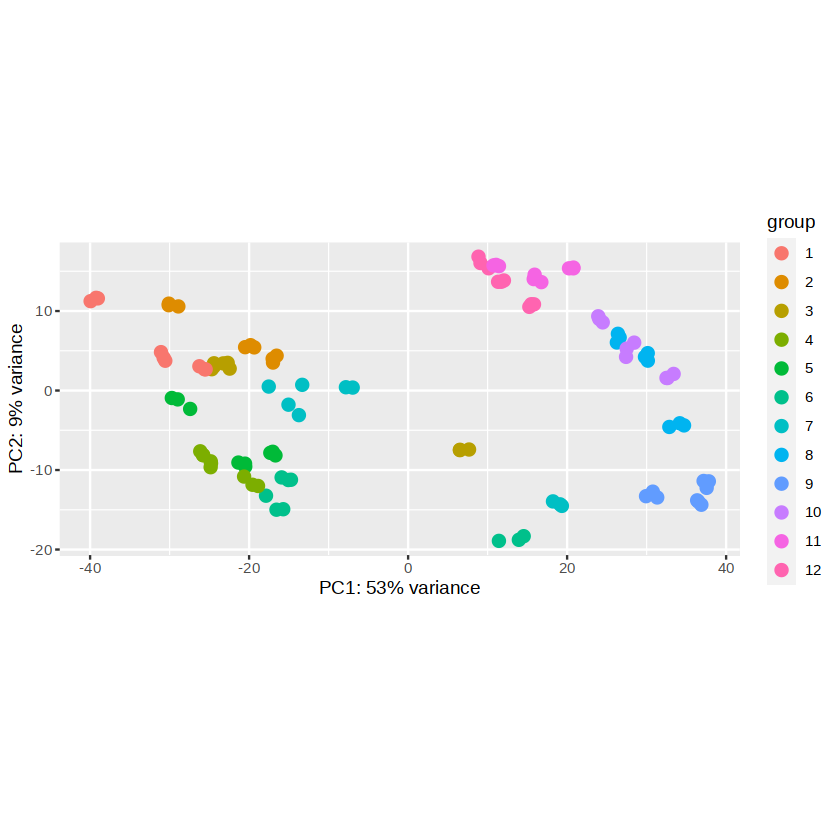

In [ ]:
# =============================================================================
# PCA VISUALIZATION
# =============================================================================

cat("Generating PCA plots for batch-corrected data...\n")

# Set plot dimensions
options(repr.plot.width=PLOT_WIDTH, repr.plot.height=PLOT_HEIGHT)

# PCA colored by sample
cat("Creating PCA plot colored by sample...\n")
plotPCA(vsd, intgroup=c('sample')) + 
  ggtitle("PCA: Batch-Corrected Data (Colored by Sample)") +
  theme_minimal()

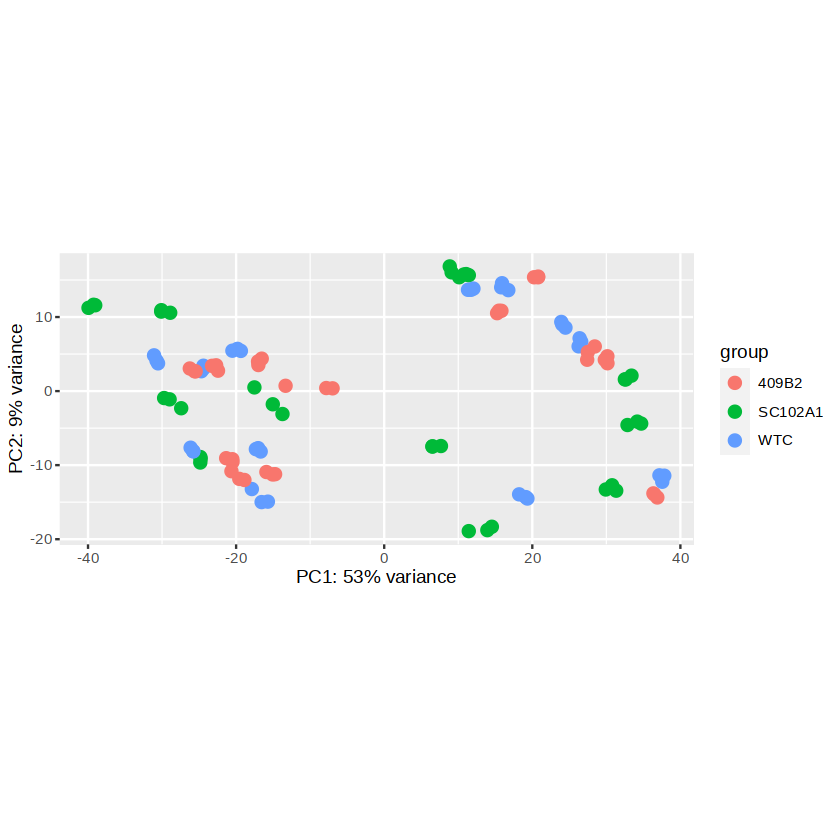

In [ ]:
# PCA colored by genotype
cat("Creating PCA plot colored by genotype...\n")
plotPCA(vsd, intgroup=c('genotype')) + 
  ggtitle("PCA: Batch-Corrected Data (Colored by Genotype)") +
  theme_minimal()

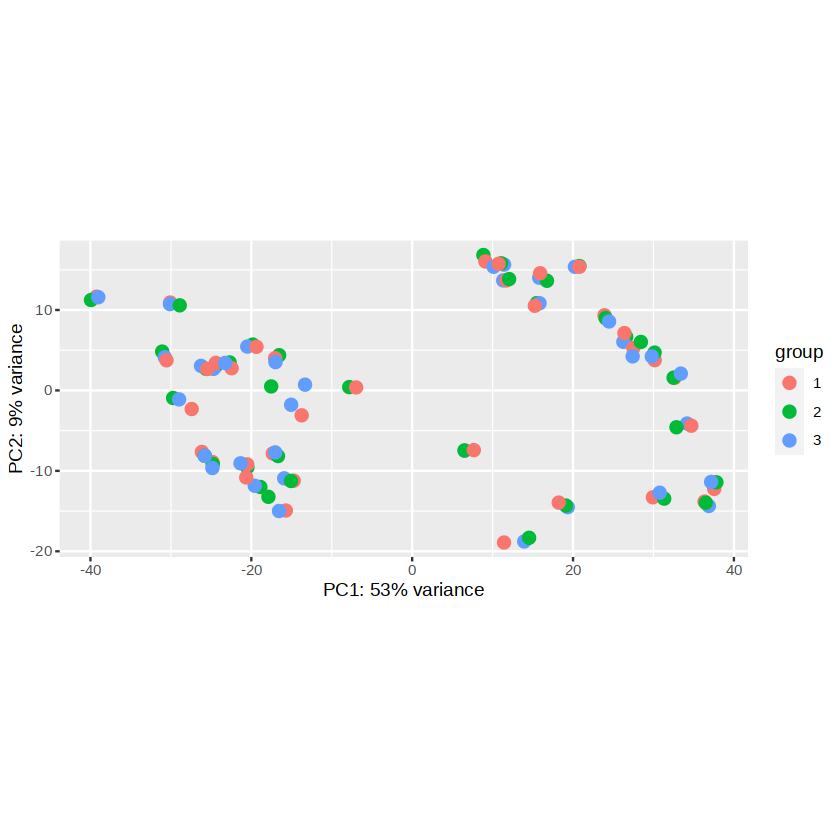

In [ ]:
# PCA colored by replicate (if available)
if ("replicate" %in% colnames(colData(vsd))) {
  cat("Creating PCA plot colored by replicate...\n")
  plotPCA(vsd, intgroup=c('replicate')) + 
    ggtitle("PCA: Batch-Corrected Data (Colored by Replicate)") +
    theme_minimal()
} else if ("repl" %in% colnames(colData(vsd))) {
  cat("Creating PCA plot colored by replicate...\n")
  plotPCA(vsd, intgroup=c('repl')) + 
    ggtitle("PCA: Batch-Corrected Data (Colored by Replicate)") +
    theme_minimal()
} else {
  cat("Note: No replicate information available for PCA coloring\n")
}

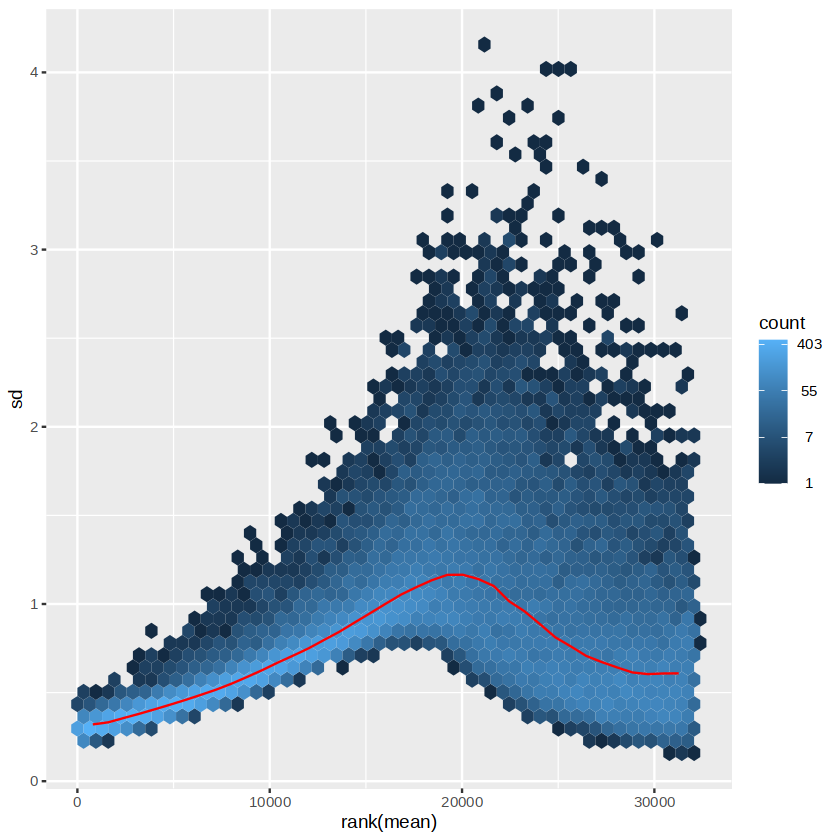

In [ ]:
# =============================================================================
# TRANSFORMATION DIAGNOSTICS AND HEATMAPS
# =============================================================================

cat("Generating transformation diagnostics...\n")

# Mean-SD plot for transformation assessment
ntd <- normTransform(dds)  # log2(n + 1) transformation
meanSdPlot(assay(ntd)) 
title("Mean-SD Plot: Log2 Transformation")

# Generate expression heatmap for top variable genes
cat("Creating expression heatmap for top expressed genes...\n")

# Select top expressed genes
top_genes <- order(rowMeans(counts(dds, normalized=TRUE)), decreasing=TRUE)[1:N_TOP_GENES]

# Create annotation dataframe
annotation_cols <- c("genotype", "sample")
if ("repl" %in% colnames(colData(dds))) {
  annotation_cols <- c(annotation_cols, "repl")
}
df_annotation <- as.data.frame(colData(dds)[, annotation_cols])

# Generate heatmap with batch-corrected VST data
options(repr.plot.width=HEATMAP_WIDTH, repr.plot.height=10)
pheatmap(assay(vsd)[top_genes, ], 
         cluster_rows=FALSE, 
         show_rownames=TRUE,
         cluster_cols=TRUE, 
         annotation_col=df_annotation,
         main="Expression Heatmap: Top Genes (Batch-Corrected VST)",
         fontsize_row=8)

In [ ]:
# =============================================================================
# SAMPLE DISTANCE ANALYSIS
# =============================================================================

cat("Calculating sample distances...\n")

# Calculate sample distances using batch-corrected VST data
sampleDists <- dist(t(assay(vsd)))
cat("✓ Sample distances calculated using Euclidean distance\n")

# Convert to matrix and save
distance_matrix <- as.matrix(sampleDists)
distance_file <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_limma_corr_pca_distances.tsv")
write.table(distance_matrix, distance_file, sep="\t")
cat("✓ Distance matrix saved:", distance_file, "\n")

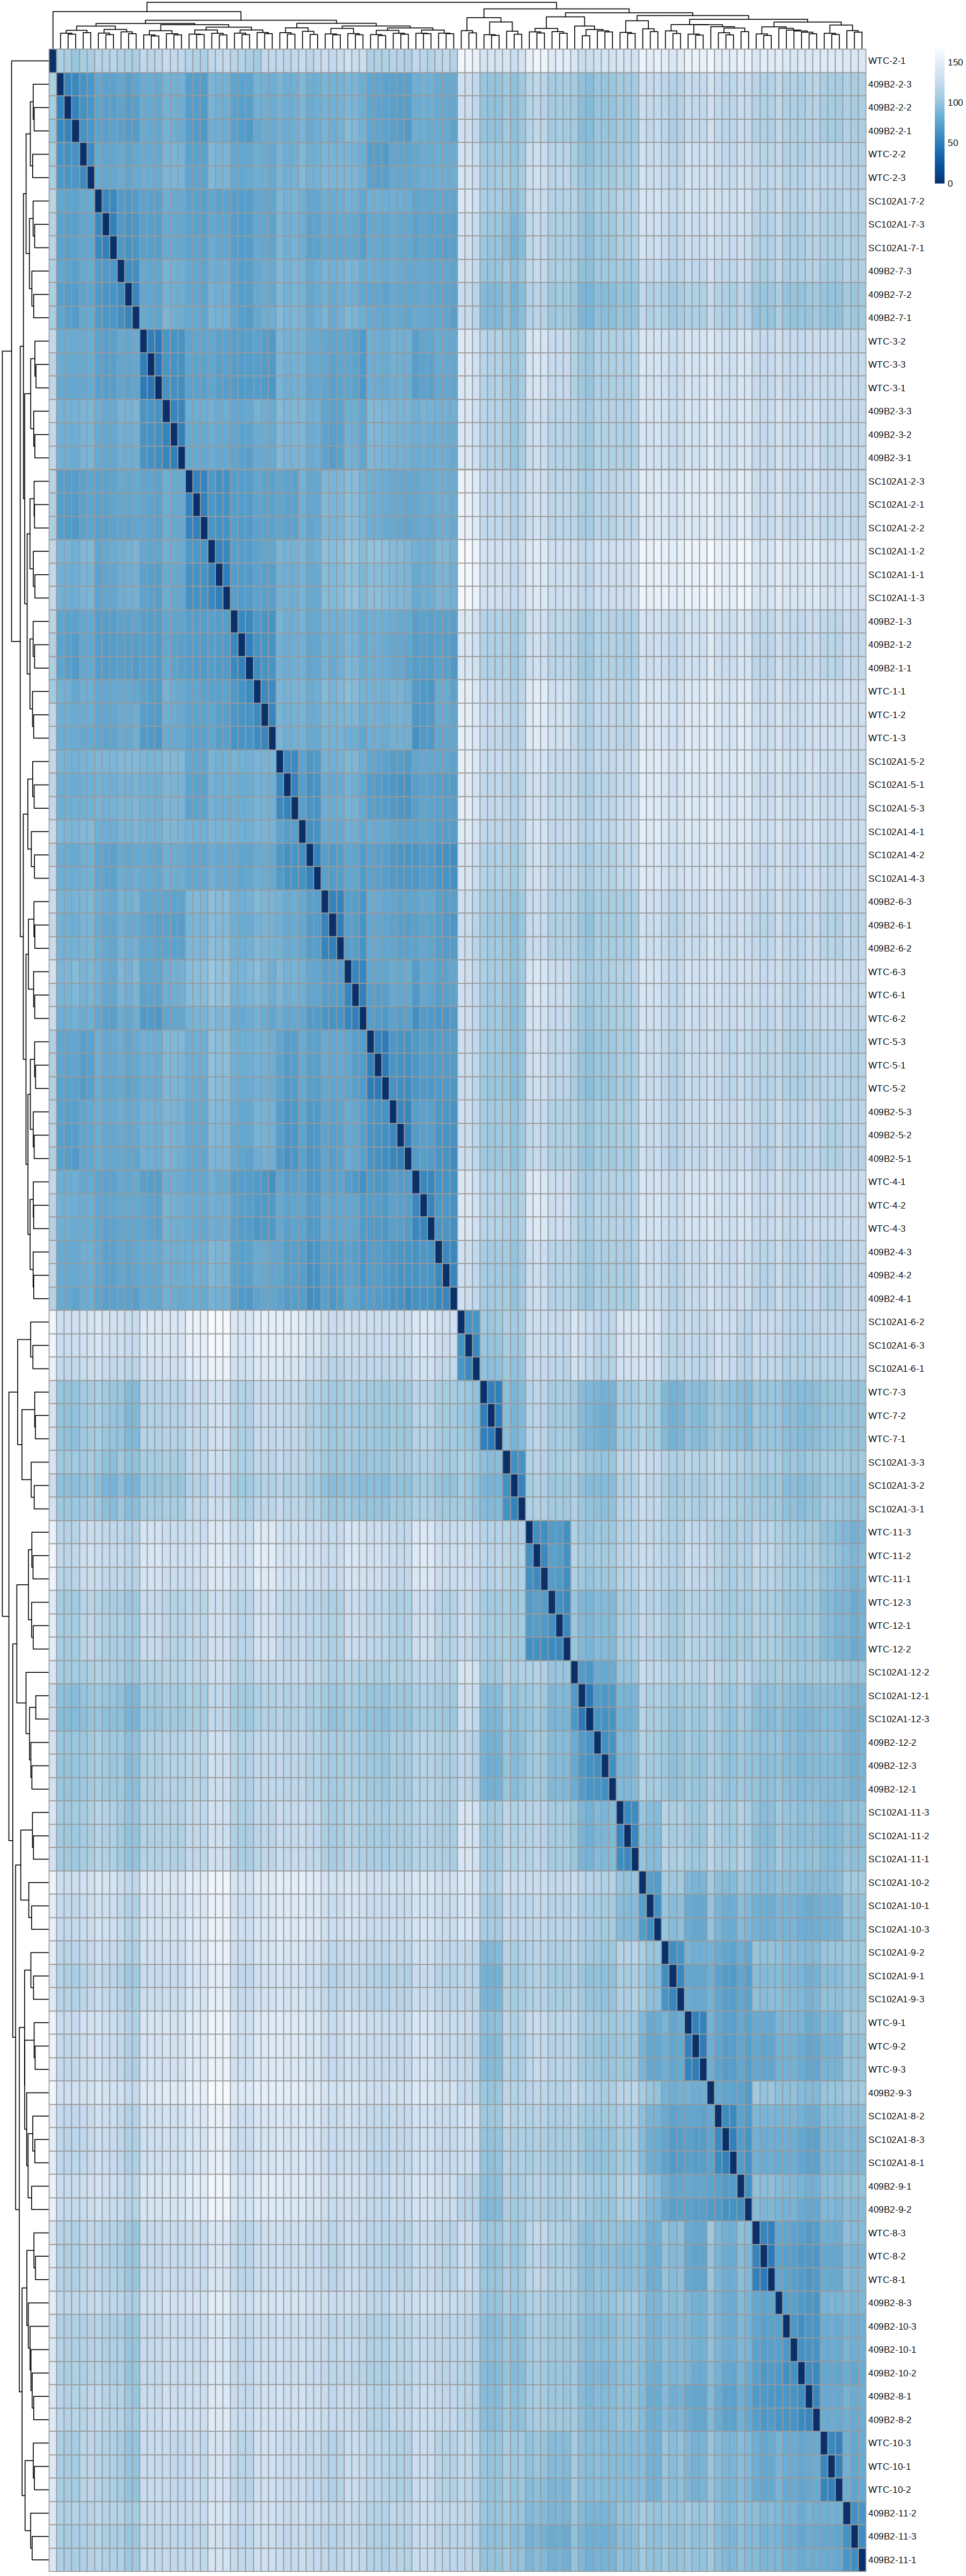

In [ ]:
library("RColorBrewer")

# =============================================================================
# DISTANCE HEATMAP VISUALIZATION
# =============================================================================

cat("Creating sample distance heatmap...\n")

# Prepare distance matrix for visualization
sampleDistMatrix <- distance_matrix

# Create informative row names combining genotype, sample, and replicate info
row_labels <- paste(vsd$genotype, vsd$sample, sep="-")
if ("repl" %in% colnames(colData(vsd))) {
  row_labels <- paste(row_labels, vsd$repl, sep="-")
}

rownames(sampleDistMatrix) <- row_labels
colnames(sampleDistMatrix) <- NULL

# Create color palette
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)

# Set plot size for distance heatmap
options(repr.plot.width=HEATMAP_WIDTH, repr.plot.height=HEATMAP_HEIGHT)

# Generate distance heatmap
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         main="Sample Distance Heatmap (Batch-Corrected Data)",
         fontsize_row=10)

cat("✓ Sample distance heatmap generated\n")

## 6. Sample-Specific Marker Gene Analysis

In [ ]:
# =============================================================================
# SAMPLE-SPECIFIC MARKER GENE ANALYSIS
# =============================================================================

cat("Performing sample-specific marker gene analysis...\n")

# Get sample information and prepare for pairwise comparisons
sampleInfo <- deseq2.colData
sampleNames <- levels(sampleInfo$sample)
cat("Analyzing", length(sampleNames), "samples:", paste(sampleNames, collapse=", "), "\n")

# Initialize list to store marker gene results
markerGenesList <- list()

# Perform one-vs-all comparisons for each sample
for (sample_id in sampleNames) {
    cat("Processing sample", sample_id, "vs all others...\n")
    
    # Create binary condition: current sample vs all others
    sampleVsOthers <- relevel(
        factor(ifelse(sampleInfo$sample == sample_id, sample_id, "others")), 
        ref = "others"
    )
    
    # Update colData with the new condition
    temp_colData <- sampleInfo
    temp_colData$condition <- sampleVsOthers
    
    # Create new DESeq2 dataset for this comparison
    # Include time as covariate if available, otherwise just use condition
    design_formula <- if("t_int" %in% colnames(temp_colData)) {
        ~ t_int + condition
    } else {
        ~ condition  
    }
    
    dds_temp <- DESeqDataSetFromMatrix(
        countData = total, 
        colData = temp_colData,
        design = design_formula
    )
    
    # Apply same gene filtering as main analysis
    keep_genes <- rowSums(counts(dds_temp)) >= MIN_GENE_COUNT
    dds_temp <- dds_temp[keep_genes, ]
    
    # Run DESeq2 analysis
    dds_temp <- DESeq(dds_temp)
    
    # Extract results for sample vs others comparison
    res_temp <- results(dds_temp, contrast = c("condition", sample_id, "others"))
    markerGenesList[[sample_id]] <- res_temp
    
    cat("✓ Sample", sample_id, "analysis complete\n")
}

cat("✓ All sample-specific marker analyses completed\n")


[1] "1"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "2"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 144 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "3"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 150 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "4"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 153 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "5"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 155 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "6"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "7"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 157 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "8"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 185 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "9"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 145 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "10"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 164 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "11"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "12"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
# =============================================================================
# RESULTS EXPORT AND VISUALIZATION
# =============================================================================

cat("Generating volcano plots and exporting results for each sample...\n")

# Set plot dimensions for volcano plots
options(repr.plot.width=PLOT_WIDTH, repr.plot.height=PLOT_HEIGHT)

# Create output directory if it doesn't exist
if (!dir.exists(OUTPUT_DIR)) {
  dir.create(OUTPUT_DIR, recursive = TRUE)
}

# Process each sample's results
for (sample_id in sampleNames) {
    cat("Generating outputs for sample", sample_id, "...\n")
    
    res_sample <- markerGenesList[[sample_id]]
    
    # Generate volcano plot
    volcano_plot <- EnhancedVolcano(
        res_sample,
        lab = rownames(res_sample),
        x = 'log2FoldChange',
        y = 'pvalue',
        pCutoff = 0.05,
        FCcutoff = 1,
        title = paste('Sample', sample_id, 'vs Others'),
        subtitle = 'Differential Expression Analysis',
        caption = 'Log2 fold change vs. p-value',
        labSize = 3,
        pointSize = 2
    )
    
    # Save volcano plot
    plot_file <- file.path(OUTPUT_DIR, paste0(sample_id, "_deseq2.png"))
    ggsave(plot_file, volcano_plot, width = 14, height = 10, units = "cm", dpi = 300)
    cat("  ✓ Volcano plot saved:", plot_file, "\n")
    
    # Save results table
    results_file <- file.path(OUTPUT_DIR, paste0(sample_id, "_deseq2.tsv"))
    write.table(as.data.frame(res_sample), results_file, sep="\t")
    cat("  ✓ Results table saved:", results_file, "\n")
}

cat("✓ All sample results exported successfully\n")



## Analysis Summary and Session Information

This notebook completed comprehensive differential expression analysis for reproducibility assessment:

### Key Results:
1. **Data Quality Control**: Filtered samples based on library size threshold and assessed data quality
2. **DESeq2 Analysis**: Performed robust differential expression analysis with proper design accounting for genotype and sample effects
3. **Data Transformation**: Applied variance stabilizing transformation and batch correction to remove technical variation
4. **Visualization**: Generated PCA plots, expression heatmaps, and sample distance matrices to assess data structure
5. **Marker Gene Analysis**: Identified sample-specific marker genes using one-vs-all comparisons
6. **Results Export**: Generated volcano plots and exported differential expression results for each sample

### Output Files Generated:
- `bulk/reproducibility_genotypes_deseq2_vsd.tsv`: Variance stabilized expression data (original)
- `bulk/reproducibility_genotypes_deseq2_vsd_corr.tsv`: Batch-corrected expression data
- `bulk/reproducibility_genotypes_deseq2_limma_corr_pca_distances.tsv`: Sample distance matrix
- `stability_plots/[sample]_deseq2.tsv`: Differential expression results for each sample
- `stability_plots/[sample]_deseq2.png`: Volcano plots for each sample

### Analysis Parameters:
- Minimum library size threshold: `r MIN_COUNT_THRESHOLD`
- Minimum gene count threshold: `r MIN_GENE_COUNT`
- Number of samples analyzed: `r length(sampleNames)`
- Design formula: ~ genotype + sample
- Batch correction: limma::removeBatchEffect (removing genotype effects, preserving sample effects)

The analysis provides a comprehensive foundation for assessing reproducibility across experimental conditions and identifying condition-specific expression patterns.

In [ ]:
# =============================================================================
# SESSION INFORMATION FOR REPRODUCIBILITY
# =============================================================================

cat("=============================================================================\n")
cat("SESSION INFORMATION\n")
cat("=============================================================================\n")
cat("Analysis completed:", format(Sys.time(), "%Y-%m-%d %H:%M:%S"), "\n")
cat("R version:", R.version.string, "\n")
cat("Platform:", R.version$platform, "\n")
cat("Working directory:", getwd(), "\n")
cat("\n")

cat("PACKAGE VERSIONS:\n")
cat("----------------------------------------\n")
key_packages <- c("DESeq2", "limma", "ggplot2", "dplyr", "EnhancedVolcano", "pheatmap")
for(pkg in key_packages) {
  if(pkg %in% rownames(installed.packages())) {
    cat(pkg, ":", as.character(packageVersion(pkg)), "\n")
  } else {
    cat(pkg, ": not installed\n")
  }
}

cat("\n")
cat("ANALYSIS PARAMETERS:\n")
cat("----------------------------------------\n")
cat("Random seed: 42\n")
cat("Data directory:", DATA_DIR, "\n")
cat("Output directory:", OUTPUT_DIR, "\n")
cat("Min count threshold:", MIN_COUNT_THRESHOLD, "\n")
cat("Min gene count:", MIN_GENE_COUNT, "\n")
cat("Samples analyzed:", length(sampleNames), "\n")
cat("Final data dimensions:", nrow(filtered_data), "x", ncol(filtered_data), "\n")
cat("=============================================================================\n")